In [1]:
! ls /home/ian.harry/tmp_abi

template_bank  test  train  training_labels.csv


In [2]:
#Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import sem

#Machine learning tool

import keras
import tensorflow 
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GlobalAveragePooling2D, Convolution2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image

from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

import torch
from nnAudio.Spectrogram import CQT1992v2
import efficientnet.tfkeras as efn

2022-05-23 04:37:36.828602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 04:37:36.828652: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
# I am using concepts and certain codes used by Mrigendra Agrwal from Kaggle.
#Reference https://www.kaggle.com/code/mrigendraagrawal/tf-g2net-eda-and-starter

In [4]:
#Read in the training labels csv and assign paths
training_labels = pd.read_csv("/home/ian.harry/tmp_abi/training_labels.csv")

path = list(training_labels['id'])
for i in range(len(path)):
    path[i] = '/home/ian.harry/tmp_abi/train/' + path[i][0] +  '/' + path[i][1] +  '/' + path[i][2] +  '/' + path[i] + '.npy'
    



In [5]:
#Function to set a path to call in the data
def path2id(idx,is_train = True):
    path = '/home/ian.harry/tmp_abi'
    if is_train:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    else:
        path += '/train/' + idx[0] + '/' + idx[1] + '/' + idx[2] + '/' + idx + '.npy'
    return path

In [6]:
#function to plot time series of each detector and for a q-scan.
def increase_dimension(idx,is_train,transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)): 
    
    waves = np.load(path2id(idx,is_train)) #loads the data 
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves) # converts into an image
    image = np.array(image)
    image = np.transpose(image,(1,2,0))
    return image

CQT kernels created, time used = 0.0348 seconds


/home/abi.abraham/.local/lib/python3.9/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [9]:
ex_ts.savefig("ex_ts.pdf",format="pdf", bbox_inches ="tight")

In [10]:
#Dataset Generator 
class Dataset(Sequence):
    
    def __init__(self,idx,y=None,batch_size=32, shuffle= True):
        self.idx = idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train=True
        else:
            self.is_train=False
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    def __getitem__(self,ids):
        batch_ids = self.idx[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x = np.array([increase_dimension(x,self.is_train) for x in batch_ids])
        batch_X = np.stack(list_x)
        
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))
    
    def debug(self):
        return self.idx

In [11]:
#Reducing the size of dataset 
train_data_size = len(training_labels['id'].values)//100 #reducing the data size to 5600 
train_idx = training_labels['id'].values[0:train_data_size]
valid_idx = training_labels['target'].values[0:train_data_size]
test_idx =  training_labels['id'].values[5600:11200]

In [12]:
print(len(train_idx))
print(len(test_idx))

5600
5600


In [13]:
#Spliting the dataset in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(train_idx,valid_idx,test_size=0.20, random_state=None, stratify=valid_idx)

In [14]:
#Applying the dataset generator to train, test and validation sets
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_test, y_test)
test_dataset  = Dataset(test_idx)
len(y_train)

4480

In [15]:
#Building the CNN model
#input shape decided from examples and trial and error. 
model = Sequential([keras.layers.InputLayer(input_shape=(63,193,1)), Convolution2D(3,3,activation='relu',padding='same'), 
                   efn.EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'), 
                   GlobalAveragePooling2D(),
                   Dense(32,activation='relu'), 
                   Dense(1,activation='sigmoid')])

model.summary()
model.compile(optimizer= Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=["accuracy"]) # loss is binary_crossentropy, this is for binary classification. 

2022-05-23 04:37:45.846004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-23 04:37:45.846059: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-23 04:37:45.846100: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ldas-pcdev14): /proc/driver/nvidia/version does not exist
2022-05-23 04:37:45.846426: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 193, 3)        30        
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,090,619
Trainable params: 4,048,603
Non-

In [16]:
#Training the model
model.fit(train_dataset, validation_data=valid_dataset, use_multiprocessing=True,
          epochs = 5)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1/5
140/140 [==============================] - 292s 2s/step - loss: 0.7011 - accuracy: 0.5121 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 2/5
140/140 [==============================] - 290s 2s/step - loss: 0.6259 - accuracy: 0.6359 - val_loss: 0.6971 - val_accuracy: 0.4991
Epoch 3/5
140/140 [==============================] - 282s 2s/step - loss: 0.5250 - accuracy: 0.7326 - val_loss: 0.7379 - val_accuracy: 0.5000
Epoch 4/5
140/140 [==============================] - 287s 2s/step - loss: 0.4833 - accuracy: 0.7614 - val_loss: 0.7018 - val_accuracy: 0.5080
Epoch 5/5
140/140 [==============================] - 295s 2s/step - loss: 0.4319 - accuracy: 0.8016 - val_loss: 0.6077 - val_accuracy: 0.6313


In [17]:
model.save('Project/Model')

2022-05-23 05:02:14.962589: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Project/Model/assets


In [18]:
loaded_model = keras.models.load_model('Project/Model')

In [19]:
df = pd.DataFrame(list()) 
df.to_csv('predsv0.csv')
predsv0 = pd.read_csv('predsv0.csv')

In [20]:
#Model prediciting the using the test sets
model_pred = loaded_model.predict(test_dataset, use_multiprocessing=True,verbose=1)
model_pred = model_pred.reshape(-1)

175/175 [==============================] - 177s 997ms/step


In [26]:
print(len(training_labels))
print(len(train_idx))
print(len(model_pred))

560000
5600
5600


In [27]:
train_data_size2 = len(y_train)
test_idx2 = training_labels['id'].values[5600:11200]

targets_s = training_labels['target']
tar_len = (len(targets_s)//100) 
targets = training_labels['target'].values[5600:11200]
print(len(targets))

5600


In [28]:
print(model_pred)
print(len(model_pred))

[0.99900734 0.3774139  0.42695367 ... 0.550153   0.45388472 0.31550458]
5600


In [40]:
model_target = np.array(model_pred)
model_target[:,] = model_target[:,]>0.31 # setting threshold to create a binary classification
model_targets = model_target.astype(int)
print(model_targets)
print(len(targets)) 
    

[1 1 1 ... 1 1 1]
5600


In [41]:
#To find the best threshold
threshs = np.linspace(0,1,10000)

max_icv = 0

for th in threshs:

    icv = predsv0['Model Predictions'] > th
    curr_th = sum(icv == predsv0['Actual Targets']) / len(predsv0)
    if curr_th > max_icv:
        max_icv = curr_th
        max_th = th
print(max_icv, max_th)

0.6439285714285714 0.5171517151715171


In [42]:
#Converting the model predicition to 1 and 0s considering the threshold
target_frac = []
mod_tar = list(model_targets)
act_tar = list(targets)

for i in range(len(mod_tar)):
    if mod_tar[i] == act_tar[i]:
        target_frac.append(1)
    else: 
        target_frac.append(0)

In [43]:
predsv0 = pd.DataFrame({'id':test_idx2,'Model Predictions':model_pred, 
                      'Model Targets':model_targets,
                      'Actual Targets' : targets,
                      'Classified Targets': target_frac})

predsv0.to_csv('predsv0.csv',index = False)

In [44]:
predsv0.head(10)

,id,Model Predictions,Model Targets,Actual Targets,Classified Targets
0,027cec30f9,0.999007,1,1,1
1,027cf728b9,0.377414,1,1,1
2,027d229a6f,0.426954,1,1,1
3,027d4b8485,0.402138,1,1,1
4,027d757b08,0.515242,1,0,0
5,027d8c4c41,0.699068,1,1,1
6,027d8e0d1c,0.958617,1,1,1
7,027d931ac5,0.415407,1,0,0
8,027dd705d4,0.461839,1,1,1
9,027ddd3377,0.386381,1,1,1


In [45]:
num_ones = np.count_nonzero(target_frac)
acc_score = (num_ones/len(target_frac))*100
error_score = (100-acc_score)
print('Classfied Correctly: ', acc_score, 'Classfied Incorrectly: ', error_score)


Classfied Correctly:  49.23214285714286 Classfied Incorrectly:  50.76785714285714


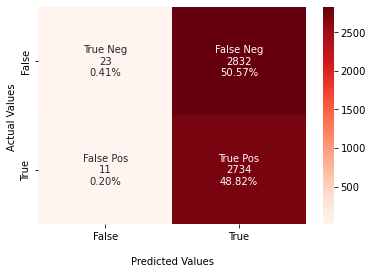

In [47]:
cm = confusion_matrix(act_tar,mod_tar) #Computes a confusion matrix 
group_names = ['True Neg','False Neg','False Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')


ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
cm_CNNv0 = plt.gcf()

In [48]:
cm_CNNv0.savefig('cm_CNNv0.pdf',format='pdf',bbox_inches='tight')